# 频繁模式与关联规则挖掘：

- 对数据集进行处理，转换成适合进行关联规则挖掘的形式
- 找出频繁模式
- 导出关联规则，计算其支持度和置信度
- 对规则进行评价，可使用Lift、卡方和其它教材中提及的指标, 至少2种
- 对挖掘结果进行分析
- 可视化展示

项目地址：

选择数据集：wine-reviews

## 1.数据的简要说明

该数据集包含两个csv文件，分别为：
- winemag-data_first150k.csv
- winemag-data-130-v2.csv

两个文件的属性名称大部分都是相同的，除了winemag-data-130k-v2.csv中多出taster_name，taster_twitter_handle以及title，

其余相同的属性包括：['Unnamed: 0' 'country' 'description' 'designation' 'points' 'price' 'province' 'region_1' 'region_2' 'variety' 'winery']

一共有13个可用的属性，分别如下所示：

- Unnamed: 0：行号；

- country：The country that the wine is from（葡萄酒的原产国），为标称属性；

- description：对该酒的评价；

- designation：The vineyard within the winery where the grapes that made the wine are from（酿酒厂内的葡萄园，酿制葡萄酒的葡萄的来源）；

- points：The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score &gt;=80)；

- price：The cost for a bottle of the wine；

- province：The province or state that the wine is from（出产葡萄酒的省或州）；

- region_1：The wine growing area in a province or state (ie Napa)（一个省或州的葡萄酒产区(如纳帕)）；

- region_2：Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank（有时在葡萄酒的生长区域内会指定更特定的区域(如纳帕谷内的卢瑟福)，但这个值有时可以为空）；

- variety：The type of grapes used to make the wine (ie Pinot Noir)（用来酿酒的葡萄品种(如黑比诺)）；

- winery：酒庄；

- taster_name：评价者的姓名；

- taster_twitter_handle：评价者的推特地址；

- title：The title of the wine review, which often contains the vintage if you're interested in extracting that feature（葡萄酒评论的标题，如果你有兴趣提取这一特征，通常会包含年份；

## 2.数据的初步处理

为了将数据转换为适合进行关联规则挖掘的形式：
- 首先将与挖掘任务明显无关的属性进行去除，包括属性：Unnamed: 0, description。其中，Unnamed: 0是行号，具有唯一性，没有讨论价值；description是葡萄酒评论的具体评论，可用于文本挖掘，但是也具有唯一性，故亦删除之。
- 其次，该数据中和地理位置相关的属性值包括：country, province, region_1, region_2, designation, winery，一共有六个，按照空间大小从大到小排列。粒度最小的属性为winery，尽管winery相同但地区不同的情况是存在的，但是由于该数据没有缺失值，同时针对葡萄酒而言，酒庄应该是地理位置中相对最重要的信息，同时考虑到其余的相关属性会导致复杂度的提升，因此使用winery进行挖掘。
- 此外，还有一个属性title也包含了地理信息，作业一中，130k数据已经使用title对region_1的缺失值进行补充。
- price，points都是数值属性，为了节约计算资源，需要对这两个属性值进行离散化。

处理过程如下所示：

In [9]:
import os
import pandas as pd
import numpy as np

def file_filter(f):
        if f[-4:] in ['.csv']:
            return True
        else:
            return False

def get_file_list(dir_):
    lists = os.listdir(dir_)
    lists = list(filter(file_filter, lists))
    return lists

file_path_arr = get_file_list(os.path.abspath(os.curdir))

print(file_path_arr)

['winemag-data-130k-v2.csv', 'winemag-data_first150k.csv']


首先，查看points和price的频数分布图，从而考虑如何离散化。

current file name:  winemag-data-130k-v2.csv
88     17198
87     16927
90     15403
86     12595
89     12208
91     11353
92      9606
85      9529
93      6489
84      6478
94      3758
83      3024
82      1835
95      1535
81       692
96       523
80       397
97       229
98        77
99        33
100       19
Name: points, dtype: int64


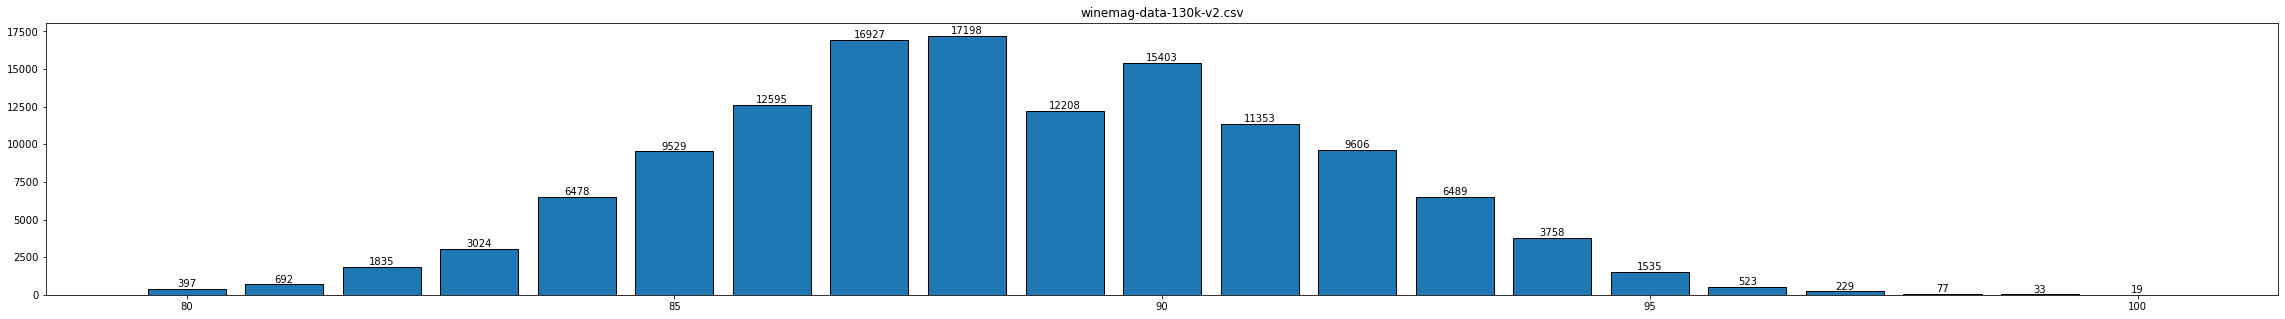

In [10]:
import matplotlib.pyplot as plt

def hist_bar(index, number, whole_data_):
        plt.figure(figsize=(40, 5))
        plt.title(file_path_arr[index])
        X = whole_data_[index][attribute].value_counts().index[:number]
        Y = whole_data_[index][attribute].value_counts().values[:number]
        plt.bar(X, Y, edgecolor='black')
        for x, y in zip(X, Y):
                plt.text(x, y, '%d' % y, ha='center', va='bottom')

def figure_by_attribute(file_index, attribute, whole_data_):
        print("current file name: ", file_path_arr[file_index])
        current_data = whole_data_[file_index]
        bin_data = current_data[attribute].value_counts(dropna = False)
        print(bin_data)
        hist_bar(file_index, 40, whole_data_)


whole_data = []
for current_file in file_path_arr:
        whole_data.append(pd.read_csv(current_file, low_memory=False))
attribute = 'points'
figure_by_attribute(0, attribute, whole_data)

current file name:  winemag-data_first150k.csv
87     20747
88     17871
90     15971
86     15573
89     12921
85     12411
84     10708
91     10536
92      9241
83      6048
93      6017
82      4041
94      3462
95      1716
81      1499
80       898
96       695
97       365
98       131
99        50
100       24
Name: points, dtype: int64


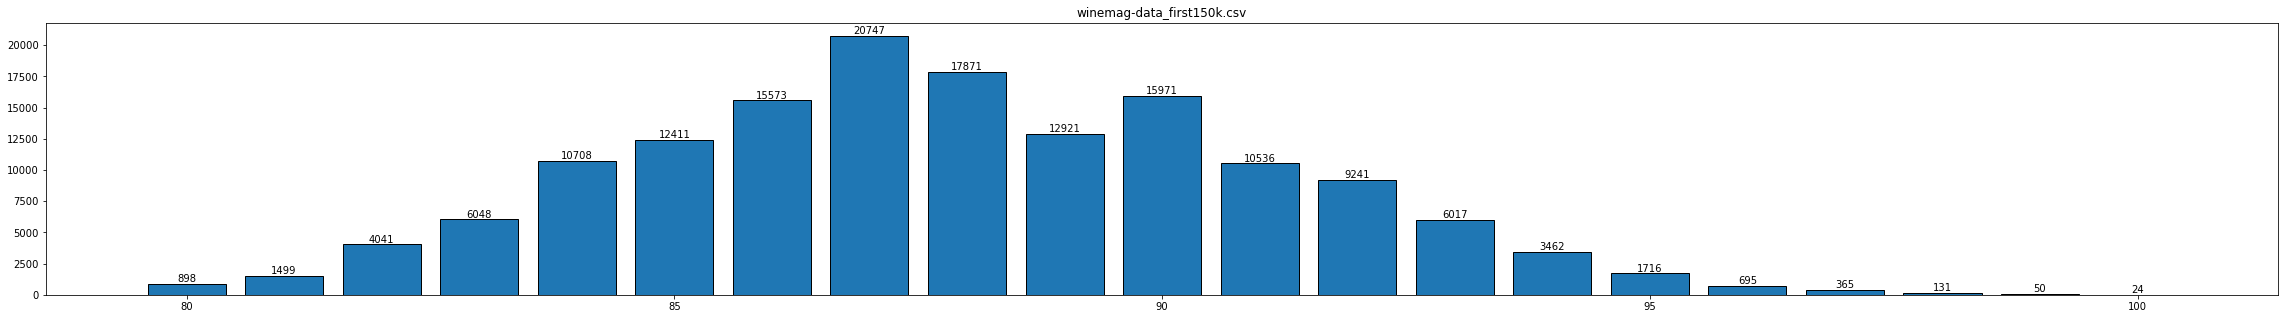

In [11]:
figure_by_attribute(1, attribute, whole_data)

current file name:  winemag-data-130k-v2.csv
20.0      13661
15.0       6197
25.0       5893
30.0       5032
18.0       4977
          ...  
247.0         1
630.0         1
1900.0        1
602.0         1
540.0         1
Name: price, Length: 390, dtype: int64


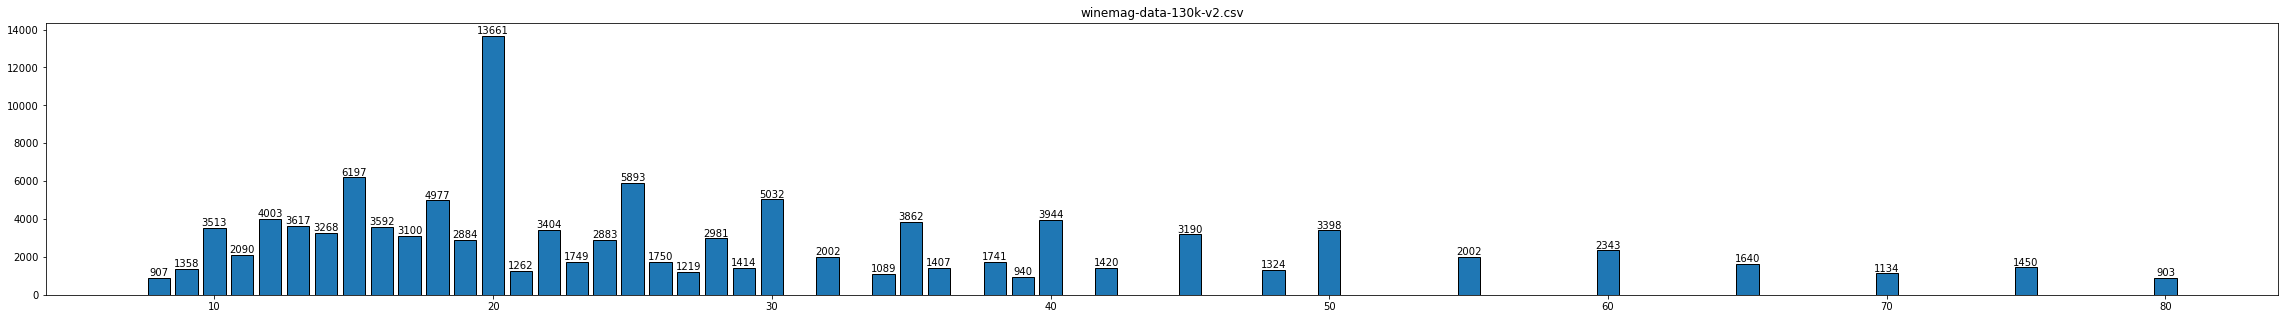

In [12]:
attribute = 'price'
figure_by_attribute(0, attribute, whole_data)

current file name:  winemag-data_first150k.csv
20.0     17968
15.0      7264
18.0      6126
25.0      6124
30.0      5574
         ...  
545.0        1
351.0        1
319.0        1
698.0        1
540.0        1
Name: price, Length: 362, dtype: int64


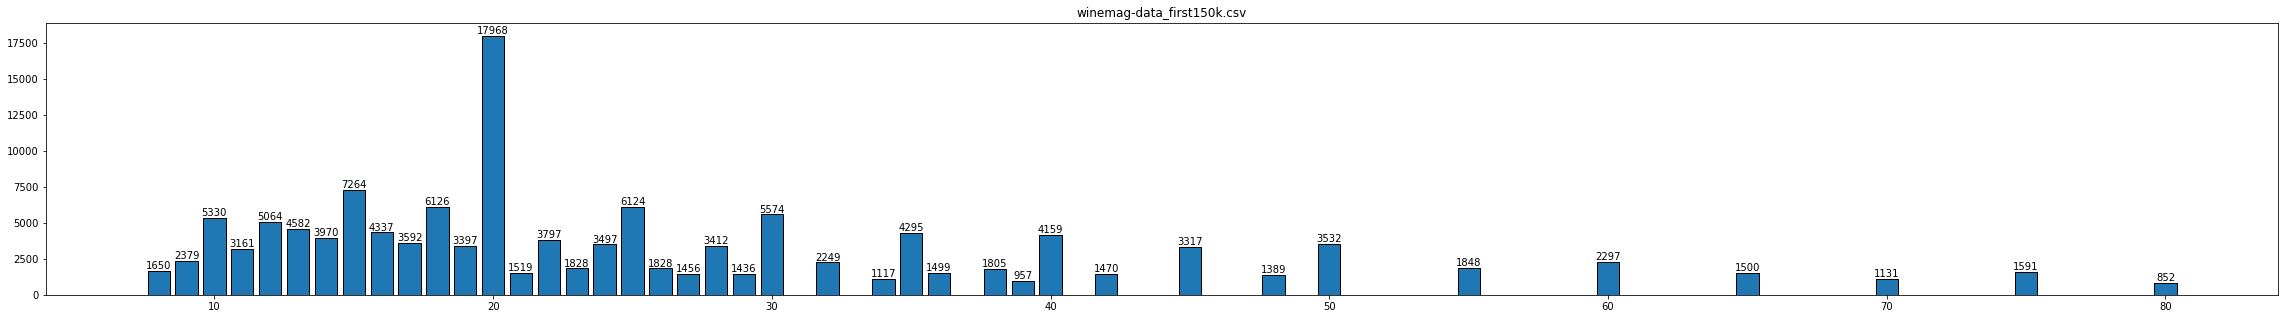

In [13]:
figure_by_attribute(1, attribute, whole_data)

从上面可以看出：
- price的分布大多数处于100以下，因此大于100的价格统一记为11，其余的整除10
- points分布在80-100中，所以除以(100/(100-80))=5

同时，为了导出规则，对price和points数据值进行格式化

In [14]:
def points_discretization(value):
    return "points_"+str(round(value/5))

def price_discretization(value):
    if value < 100:
        return "price_"+str(round(value/10))
    else:
        return "price_11"


In [15]:
data_130k = pd.read_csv(file_path_arr[0])
data_150k = pd.read_csv(file_path_arr[1])

data_130k = data_130k.drop(['Unnamed: 0','description','country', 'province','region_1','region_2','designation'],axis = 1)
data_150k = data_150k.drop(['Unnamed: 0','description','country', 'province','region_1','region_2','designation'],axis = 1)

data_130k.loc[:,'points'] = data_130k['points'].map(lambda x:points_discretization(x))
data_130k.loc[:,'price'] = data_130k['price'].map(lambda x:price_discretization(x))
data_150k.loc[:,'points'] = data_150k['points'].map(lambda x:points_discretization(x))
data_150k.loc[:,'price'] = data_150k['price'].map(lambda x:price_discretization(x))

In [16]:
data_130k = np.array(data_130k)
data_130k_arr =data_130k.tolist()

data_150k = np.array(data_150k)
data_150k_arr =data_150k.tolist()

### 将数据处理为可以由mlxtend库读取的形式 

In [17]:
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
tf = te.fit_transform(data_150k_arr)
df = pd.DataFrame(tf,columns=te.columns_)

## 3.频繁模式计算

在这里，使用mlxten库中的Apriori算法来对频繁模式计算，最小支持度阈值取0.02。

In [98]:
from mlxtend.frequent_patterns import apriori
frequent_patterns = apriori(df, min_support=0.02, use_colnames=True, max_len=4).sort_values(by='support', ascending=False)	
print(frequent_patterns.shape)
frequent_patterns.head(30)

(51, 2)


,support,itemsets
14,0.440881,(points_18)
13,0.433904,(points_17)
18,0.393898,(price_2)
42,0.197820,"(points_17, price_2)"
16,0.180321,(price_1)
46,0.168402,"(price_2, points_18)"
41,0.135425,"(price_1, points_17)"
20,0.127852,(price_4)
19,0.120696,(price_3)
2,0.095955,(Chardonnay)


## 4.关联规则导出以及规则评价

- 通过频繁项集对关联规则进行导出，计算支持度support，置信度confidence。
- 置信度阈值设置为0.1。
- 计算规则表按Lift进行降序排序。

In [76]:
from mlxtend.frequent_patterns import association_rules	
rules =  association_rules(frequent_patterns, metric ='confidence', min_threshold = 0.1)
rules = rules.sort_values(by=['lift'], ascending=False).reset_index(drop=True)
rules = rules.drop(['leverage','conviction'],axis = 1)
print(rules.shape)
rules

(36, 7)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,(price_4),(Pinot Noir),0.127852,0.094670,0.023177,0.181281,1.914883
1,(Pinot Noir),(price_4),0.094670,0.127852,0.023177,0.244821,1.914883
2,(points_17),(price_1),0.433904,0.180321,0.135425,0.312108,1.730842
3,(price_1),(points_17),0.180321,0.433904,0.135425,0.751020,1.730842
4,(price_5),(points_18),0.049508,0.440881,0.031499,0.636242,1.443114
5,(price_6),(points_18),0.049124,0.440881,0.030439,0.619639,1.405455
6,(points_18),(price_4),0.440881,0.127852,0.078483,0.178013,1.392343
7,(price_4),(points_18),0.127852,0.440881,0.078483,0.613858,1.392343
8,(Bordeaux-style Red Blend),(price_2),0.048680,0.393898,0.026530,0.544984,1.383568
9,(Sauvignon Blanc),(price_2),0.041875,0.393898,0.022342,0.533544,1.354525


将关联规则进行导出：

In [77]:
def printRules(rules):
    for index, row in rules.iterrows():
        t1 = tuple(row['antecedents'])
        t2 = tuple(row['consequents'])
        print("%s: %s ⇒ %s (support = %f, confidence = %f )"%(index, t1,t2,row['support'],row['confidence']))


In [78]:
printRules(rules)

0: ('price_4',) ⇒ ('Pinot Noir',) (support = 0.023177, confidence = 0.181281 )
1: ('Pinot Noir',) ⇒ ('price_4',) (support = 0.023177, confidence = 0.244821 )
2: ('points_17',) ⇒ ('price_1',) (support = 0.135425, confidence = 0.312108 )
3: ('price_1',) ⇒ ('points_17',) (support = 0.135425, confidence = 0.751020 )
4: ('price_5',) ⇒ ('points_18',) (support = 0.031499, confidence = 0.636242 )
5: ('price_6',) ⇒ ('points_18',) (support = 0.030439, confidence = 0.619639 )
6: ('points_18',) ⇒ ('price_4',) (support = 0.078483, confidence = 0.178013 )
7: ('price_4',) ⇒ ('points_18',) (support = 0.078483, confidence = 0.613858 )
8: ('Bordeaux-style Red Blend',) ⇒ ('price_2',) (support = 0.026530, confidence = 0.544984 )
9: ('Sauvignon Blanc',) ⇒ ('price_2',) (support = 0.022342, confidence = 0.533544 )
10: ('points_18',) ⇒ ('price_3',) (support = 0.068305, confidence = 0.154929 )
11: ('price_3',) ⇒ ('points_18',) (support = 0.068305, confidence = 0.565931 )
12: ('Sauvignon Blanc',) ⇒ ('points_17'

## 5.关联规则的评价

- 在此，使用的评价方法包括：提升度Lift, 全置信度allconf, cosine, jaccard, maxconf以及kulczynski。
- 支持度support， 全置信度allconf，计算结果如下：

In [56]:
import math
def metrics(r,f):
    ans = []
    for i in range(r.shape[0]):
        item = r.iloc[i]
        ans.append(f(item))
    return ans
def allconf(item):
    return item.support/max(item['antecedent support'],item['consequent support'])
def cosine(item):
    return item.support/math.sqrt(item['antecedent support']*item['consequent support'])
def Jaccard(item):
    return item.support/(item['antecedent support']+item['consequent support']-item.support)
def maxconf(item):
    return max(item.support/item['antecedent support'],item.support/item['consequent support'])
def Kulczynski(item):
    return 0.5*(item.support/item['antecedent support']+item.support/item['consequent support'])

In [79]:
rules['cosine'] = metrics(rules,cosine)
rules['jaccard'] = metrics(rules,Jaccard)
rules['allconf'] = metrics(rules,allconf)
rules['maxconf'] = metrics(rules,maxconf)
rules['kulczynski'] = metrics(rules,Kulczynski)

In [80]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,jaccard,allconf,maxconf,kulczynski
0,(price_4),(Pinot Noir),0.127852,0.094670,0.023177,0.181281,1.914883,0.210669,0.116267,0.181281,0.244821,0.213051
1,(Pinot Noir),(price_4),0.094670,0.127852,0.023177,0.244821,1.914883,0.210669,0.116267,0.181281,0.244821,0.213051
2,(points_17),(price_1),0.433904,0.180321,0.135425,0.312108,1.730842,0.484148,0.282842,0.312108,0.751020,0.531564
3,(price_1),(points_17),0.180321,0.433904,0.135425,0.751020,1.730842,0.484148,0.282842,0.312108,0.751020,0.531564
4,(price_5),(points_18),0.049508,0.440881,0.031499,0.636242,1.443114,0.213206,0.068642,0.071446,0.636242,0.353844
5,(price_6),(points_18),0.049124,0.440881,0.030439,0.619639,1.405455,0.206835,0.066234,0.069041,0.619639,0.344340
6,(points_18),(price_4),0.440881,0.127852,0.078483,0.178013,1.392343,0.330567,0.160087,0.178013,0.613858,0.395936
7,(price_4),(points_18),0.127852,0.440881,0.078483,0.613858,1.392343,0.330567,0.160087,0.178013,0.613858,0.395936
8,(Bordeaux-style Red Blend),(price_2),0.048680,0.393898,0.026530,0.544984,1.383568,0.191587,0.063766,0.067352,0.544984,0.306168
9,(Sauvignon Blanc),(price_2),0.041875,0.393898,0.022342,0.533544,1.354525,0.173963,0.054041,0.056721,0.533544,0.295133


可以看到，Lift大于1的项为前21条，说明它们之间有正相关关系；其余的则存在负相关关系；

然后按照allconf大小进行排序：

In [81]:
rules = rules.sort_values(by=['allconf'], ascending=False).reset_index(drop=True)

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,jaccard,allconf,maxconf,kulczynski
0,(price_2),(points_17),0.393898,0.433904,0.197820,0.502212,1.157426,0.478500,0.314009,0.455907,0.502212,0.479060
1,(points_17),(price_2),0.433904,0.393898,0.197820,0.455907,1.157426,0.478500,0.314009,0.455907,0.502212,0.479060
2,(price_2),(points_18),0.393898,0.440881,0.168402,0.427526,0.969708,0.404104,0.252712,0.381966,0.427526,0.404746
3,(points_18),(price_2),0.440881,0.393898,0.168402,0.381966,0.969708,0.404104,0.252712,0.381966,0.427526,0.404746
4,(points_17),(price_1),0.433904,0.180321,0.135425,0.312108,1.730842,0.484148,0.282842,0.312108,0.751020,0.531564
5,(price_1),(points_17),0.180321,0.433904,0.135425,0.751020,1.730842,0.484148,0.282842,0.312108,0.751020,0.531564
6,(price_4),(Pinot Noir),0.127852,0.094670,0.023177,0.181281,1.914883,0.210669,0.116267,0.181281,0.244821,0.213051
7,(Pinot Noir),(price_4),0.094670,0.127852,0.023177,0.244821,1.914883,0.210669,0.116267,0.181281,0.244821,0.213051
8,(points_18),(price_4),0.440881,0.127852,0.078483,0.178013,1.392343,0.330567,0.160087,0.178013,0.613858,0.395936
9,(price_4),(points_18),0.127852,0.440881,0.078483,0.613858,1.392343,0.330567,0.160087,0.178013,0.613858,0.395936


allconf越大，说明两者相关性越强，因此，将allconf小于0.07的数据去除，得到以下数据：

In [88]:
rules_ = rules.sort_values(by=['allconf'], ascending=False).reset_index(drop=True)[:26]

rules_

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,jaccard,allconf,maxconf,kulczynski
0,(price_2),(points_17),0.393898,0.433904,0.197820,0.502212,1.157426,0.478500,0.314009,0.455907,0.502212,0.479060
1,(points_17),(price_2),0.433904,0.393898,0.197820,0.455907,1.157426,0.478500,0.314009,0.455907,0.502212,0.479060
2,(price_2),(points_18),0.393898,0.440881,0.168402,0.427526,0.969708,0.404104,0.252712,0.381966,0.427526,0.404746
3,(points_18),(price_2),0.440881,0.393898,0.168402,0.381966,0.969708,0.404104,0.252712,0.381966,0.427526,0.404746
4,(points_17),(price_1),0.433904,0.180321,0.135425,0.312108,1.730842,0.484148,0.282842,0.312108,0.751020,0.531564
5,(price_1),(points_17),0.180321,0.433904,0.135425,0.751020,1.730842,0.484148,0.282842,0.312108,0.751020,0.531564
6,(price_4),(Pinot Noir),0.127852,0.094670,0.023177,0.181281,1.914883,0.210669,0.116267,0.181281,0.244821,0.213051
7,(Pinot Noir),(price_4),0.094670,0.127852,0.023177,0.244821,1.914883,0.210669,0.116267,0.181281,0.244821,0.213051
8,(price_4),(points_18),0.127852,0.440881,0.078483,0.613858,1.392343,0.330567,0.160087,0.178013,0.613858,0.395936
9,(points_18),(price_4),0.440881,0.127852,0.078483,0.178013,1.392343,0.330567,0.160087,0.178013,0.613858,0.395936


然后按照Lift进行降序排序：

In [89]:
rules_ = rules_.sort_values(by=['lift'], ascending=False).reset_index(drop=True)

rules_

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,cosine,jaccard,allconf,maxconf,kulczynski
0,(price_4),(Pinot Noir),0.127852,0.094670,0.023177,0.181281,1.914883,0.210669,0.116267,0.181281,0.244821,0.213051
1,(Pinot Noir),(price_4),0.094670,0.127852,0.023177,0.244821,1.914883,0.210669,0.116267,0.181281,0.244821,0.213051
2,(points_17),(price_1),0.433904,0.180321,0.135425,0.312108,1.730842,0.484148,0.282842,0.312108,0.751020,0.531564
3,(price_1),(points_17),0.180321,0.433904,0.135425,0.751020,1.730842,0.484148,0.282842,0.312108,0.751020,0.531564
4,(price_5),(points_18),0.049508,0.440881,0.031499,0.636242,1.443114,0.213206,0.068642,0.071446,0.636242,0.353844
5,(points_18),(price_4),0.440881,0.127852,0.078483,0.178013,1.392343,0.330567,0.160087,0.178013,0.613858,0.395936
6,(price_4),(points_18),0.127852,0.440881,0.078483,0.613858,1.392343,0.330567,0.160087,0.178013,0.613858,0.395936
7,(price_3),(points_18),0.120696,0.440881,0.068305,0.565931,1.283636,0.296107,0.138474,0.154929,0.565931,0.360430
8,(points_18),(price_3),0.440881,0.120696,0.068305,0.154929,1.283636,0.296107,0.138474,0.154929,0.565931,0.360430
9,(price_2),(points_17),0.393898,0.433904,0.197820,0.502212,1.157426,0.478500,0.314009,0.455907,0.502212,0.479060


可以看到：前16条规则中的数据是正相关的，后10条数据负相关。

## 6.结果分析以及可视化

经过上述处理，按照Lift从高到低的排序，对前16条规则进行导出：

In [90]:
rules_ = rules_.sort_values(by=['lift'], ascending=False).reset_index(drop=True)[:16]

printRules(rules_)

0: ('price_4',) ⇒ ('Pinot Noir',) (support = 0.023177, confidence = 0.181281 )
1: ('Pinot Noir',) ⇒ ('price_4',) (support = 0.023177, confidence = 0.244821 )
2: ('points_17',) ⇒ ('price_1',) (support = 0.135425, confidence = 0.312108 )
3: ('price_1',) ⇒ ('points_17',) (support = 0.135425, confidence = 0.751020 )
4: ('price_5',) ⇒ ('points_18',) (support = 0.031499, confidence = 0.636242 )
5: ('points_18',) ⇒ ('price_4',) (support = 0.078483, confidence = 0.178013 )
6: ('price_4',) ⇒ ('points_18',) (support = 0.078483, confidence = 0.613858 )
7: ('price_3',) ⇒ ('points_18',) (support = 0.068305, confidence = 0.565931 )
8: ('points_18',) ⇒ ('price_3',) (support = 0.068305, confidence = 0.154929 )
9: ('price_2',) ⇒ ('points_17',) (support = 0.197820, confidence = 0.502212 )
10: ('points_17',) ⇒ ('price_2',) (support = 0.197820, confidence = 0.455907 )
11: ('Red Blend',) ⇒ ('points_18',) (support = 0.033202, confidence = 0.498062 )
12: ('Pinot Noir',) ⇒ ('points_18',) (support = 0.044737, 

从上面的导出结果可以看到:
- 葡萄品种为Pinot Noir的酒，大多数售价为第4区间附近（规则0, 1）
- 得分在17区间附近的葡萄酒价格分布在1-2区间段内（规则2, 3, 9, 10）
- 得分在18区间附近的葡萄酒价格分布在3-5区间段内（规则4, 5, 6, 7, 8）
- 葡萄品种为Red Blend, Pinot Noir的酒，大多数得分在为第18区间附近（规则11, 12, 13）
- 葡萄品种为Chardonnay的酒，大多数得分在为第17区间附近（规则14, 15）

### 可视化

使用散点图对关联规则进行可视化：
- 横坐标为规则的支持度support；
- 纵坐标为规则的置信度condifence；
- Lift由点的深浅表示。

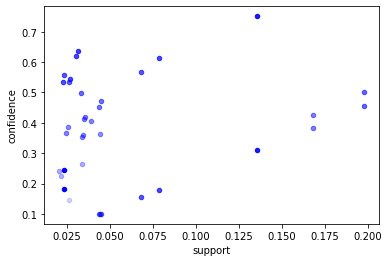

In [97]:
plt.xlabel('support')
plt.ylabel('confidence')
max_lift = max(rules.lift)
for i in range(rules.shape[0]):
    plt.scatter(rules.support[i],rules.confidence[i],s=20,c='b',alpha=rules.lift.iloc[i]/max_lift)